### model

In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from prepare import missing_values_col
from prepare import peekatdata

In [2]:
df = pd.read_csv("saas.csv")

In [3]:
df.tail(3)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0
790457,2017-12-31,1029399,5790457,0.0,0.0


In [4]:
missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
Month_Invoiced,0,0.0,0,0.0,0,0.0
Customer_Id,0,0.0,0,0.0,0,0.0
Invoice_Id,0,0.0,0,0.0,0,0.0
Subscription_Type,0,0.0,0,0.0,0,0.0
Amount,0,0.0,0,0.0,0,0.0


In [5]:
df.dtypes

Month_Invoiced        object
Customer_Id            int64
Invoice_Id             int64
Subscription_Type    float64
Amount               float64
dtype: object

In [6]:
peekatdata(df)


 
 SHAPE:
(790458, 5)

 
 COLS:
Index(['Month_Invoiced', 'Customer_Id', 'Invoice_Id', 'Subscription_Type',
       'Amount'],
      dtype='object')

 
 INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
Month_Invoiced       790458 non-null object
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB
None

 
 Missing Values:
Month_Invoiced       0
Customer_Id          0
Invoice_Id           0
Subscription_Type    0
Amount               0
dtype: int64

 
 DESCRIBE:
        Customer_Id    Invoice_Id  Subscription_Type         Amount
count  7.904580e+05  7.904580e+05      790458.000000  790458.000000
mean   1.012913e+06  5.395228e+06           0.599235       2.996174
std    7.591992e+03  2.281857e+05           0.950380       4.751901
min    1.0

In [7]:
df.describe()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
count,7.904580e+05,7.904580e+05,790458.000000,790458.000000
mean,1.012913e+06,5.395228e+06,0.599235,2.996174
std,7.591992e+03,2.281857e+05,0.950380,4.751901
min,1.000000e+06,5.000000e+06,0.000000,0.000000
25%,1.006405e+06,5.197614e+06,0.000000,0.000000
50%,1.012797e+06,5.395228e+06,0.000000,0.000000
75%,1.019154e+06,5.592843e+06,1.000000,5.000000
max,1.029399e+06,5.790457e+06,4.000000,20.000000


In [8]:
df.head(1)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0


In [9]:
def time_convert(df):
    datetime_format = '%Y %m %d'
    df['Month_Invoiced'] = pd.to_datetime(df.Month_Invoiced,format=datetime_format)
    return df

In [10]:
df = time_convert(df)

In [11]:
def add_date_parts(df):
    # year, quarter, month, day of month, day of week, weekend vs. weekday
    df['year'] = df.Month_Invoiced.dt.year
    df['quarter'] = df.Month_Invoiced.dt.quarter
    df['month'] = df.Month_Invoiced.dt.month
    df['day'] = df.Month_Invoiced.dt.day
    df['weekday'] = df.Month_Invoiced.dt.day_name().str[:3]
    df['is_weekend'] = df.weekday.str.startswith('S')
    return df

add_date_parts(df)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount,year,quarter,month,day,weekday,is_weekend
0,2014-01-31,1000000,5000000,0.0,0.0,2014,1,1,31,Fri,False
1,2014-01-31,1000001,5000001,2.0,10.0,2014,1,1,31,Fri,False
2,2014-01-31,1000002,5000002,0.0,0.0,2014,1,1,31,Fri,False
3,2014-01-31,1000003,5000003,0.0,0.0,2014,1,1,31,Fri,False
4,2014-01-31,1000004,5000004,1.0,5.0,2014,1,1,31,Fri,False
5,2014-01-31,1000005,5000005,2.0,10.0,2014,1,1,31,Fri,False
6,2014-01-31,1000006,5000006,0.0,0.0,2014,1,1,31,Fri,False
7,2014-01-31,1000007,5000007,0.0,0.0,2014,1,1,31,Fri,False
8,2014-01-31,1000008,5000008,0.0,0.0,2014,1,1,31,Fri,False
9,2014-01-31,1000009,5000009,0.0,0.0,2014,1,1,31,Fri,False


In [12]:
def new_index(df):
    df = df.set_index('Month_Invoiced')
    return df

df = new_index(df)

In [13]:
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount,year,quarter,month,day,weekday,is_weekend
Month_Invoiced,,,,,,,,,,
2014-01-31,1000000,5000000,0.0,0.0,2014,1,1,31,Fri,False
2014-01-31,1000001,5000001,2.0,10.0,2014,1,1,31,Fri,False
2014-01-31,1000002,5000002,0.0,0.0,2014,1,1,31,Fri,False
2014-01-31,1000003,5000003,0.0,0.0,2014,1,1,31,Fri,False
2014-01-31,1000004,5000004,1.0,5.0,2014,1,1,31,Fri,False


In [14]:
df.dtypes

Customer_Id            int64
Invoice_Id             int64
Subscription_Type    float64
Amount               float64
year                   int64
quarter                int64
month                  int64
day                    int64
weekday               object
is_weekend              bool
dtype: object

Split data (train/test) and resample by any period except daily, and aggregate using the sum.

In [15]:
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount,year,quarter,month,day,weekday,is_weekend
Month_Invoiced,,,,,,,,,,
2014-01-31,1000000,5000000,0.0,0.0,2014,1,1,31,Fri,False
2014-01-31,1000001,5000001,2.0,10.0,2014,1,1,31,Fri,False
2014-01-31,1000002,5000002,0.0,0.0,2014,1,1,31,Fri,False
2014-01-31,1000003,5000003,0.0,0.0,2014,1,1,31,Fri,False
2014-01-31,1000004,5000004,1.0,5.0,2014,1,1,31,Fri,False


In [16]:
df.tail()

,Customer_Id,Invoice_Id,Subscription_Type,Amount,year,quarter,month,day,weekday,is_weekend
Month_Invoiced,,,,,,,,,,
2017-12-31,1029395,5790453,0.0,0.0,2017,4,12,31,Sun,True
2017-12-31,1029396,5790454,0.0,0.0,2017,4,12,31,Sun,True
2017-12-31,1029397,5790455,3.0,15.0,2017,4,12,31,Sun,True
2017-12-31,1029398,5790456,0.0,0.0,2017,4,12,31,Sun,True
2017-12-31,1029399,5790457,0.0,0.0,2017,4,12,31,Sun,True


In [17]:
df.shape

(790458, 10)

In [18]:
aggregation = 'sum'

In [19]:
train = df[:'2016'].Amount.resample('M').agg(aggregation)
test = df['2017':].Amount.resample('M').agg(aggregation)

In [20]:
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training: %d' % (len(train.values)))
print('Testing: %d' % (len(test.values)))

Observations: 48
Training: 36
Testing: 12


In [21]:
pd.concat([train.head(3), train.tail(3)])

Month_Invoiced
2014-01-31    35850.0
2014-02-28    37190.0
2014-03-31    38295.0
2016-10-31    53190.0
2016-11-30    53375.0
2016-12-31    53320.0
Name: Amount, dtype: float64

In [22]:
pd.concat([test.head(3), test.tail(3)])

Month_Invoiced
2017-01-31    53395.0
2017-02-28    53440.0
2017-03-31    53480.0
2017-10-31    53850.0
2017-11-30    53860.0
2017-12-31    53805.0
Name: Amount, dtype: float64

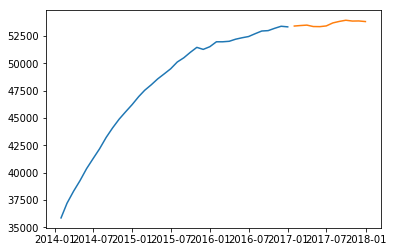

In [23]:
plt.plot(train)
plt.plot(test)
plt.show()

### Forecast, plot and evaluate using each of the 4 parametric bsed methods we discussed:
### simple average

In [24]:
y_hat = pd.DataFrame(dict(actual=test))

y_hat['avg_forecast'] = train.mean()
y_hat.tail()

,actual,avg_forecast
Month_Invoiced,,
2017-08-31,53820.0,47916.666667
2017-09-30,53925.0,47916.666667
2017-10-31,53850.0,47916.666667
2017-11-30,53860.0,47916.666667
2017-12-31,53805.0,47916.666667


In [25]:
y_hat.describe()

,actual,avg_forecast
count,12.000000,12.000000
mean,53612.500000,47916.666667
std,229.787451,0.000000
min,53340.000000,47916.666667
25%,53402.500000,47916.666667
50%,53580.000000,47916.666667
75%,53827.500000,47916.666667
max,53925.000000,47916.666667


In [26]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for y_hat in predictions:
        mse, rmse = evaluate(actual, y_hat, output=False)        
        label = f'{y_hat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(y_hat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()   

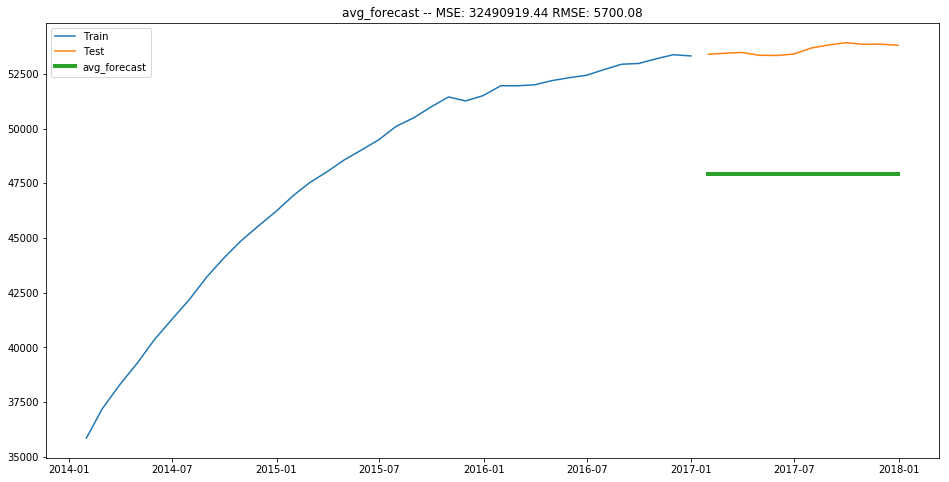

In [27]:
plot_and_eval(y_hat.avg_forecast)

### moving average

In [28]:
missing_values_col(y_hat)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
actual,0,0.0,0,0.0,0,0.0
avg_forecast,0,0.0,0,0.0,0,0.0


In [32]:
periods = 12
y_hat['moving_avg_forecast'] = train.rolling(12).mean().iloc[-1]

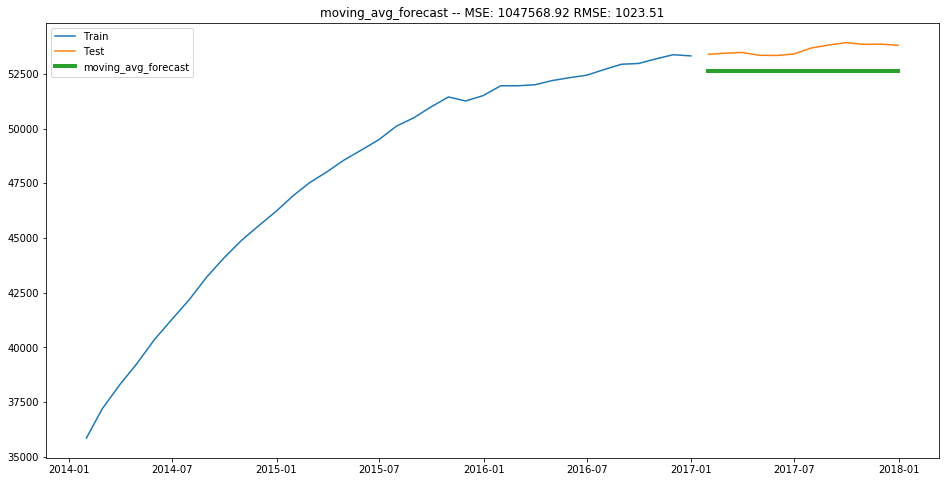

In [33]:
plot_and_eval(y_hat.moving_avg_forecast)

In [34]:
missing_values_col(y_hat)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
actual,0,0.0,0,0.0,0,0.0
avg_forecast,0,0.0,0,0.0,0,0.0
moving_avg_forecast,0,0.0,0,0.0,0,0.0


### Holt's linear trend model

In [49]:
from statsmodels.tsa.api import Holt

holt = Holt(train).fit(smoothing_level = .8, smoothing_slope = .8)
y_hat['holt_linear'] = holt.forecast(test.shape[0])

# can also play with the decimal numbers in the above smoothing level and scope parameters
# can just visually look at this to determine these smoothing numbers

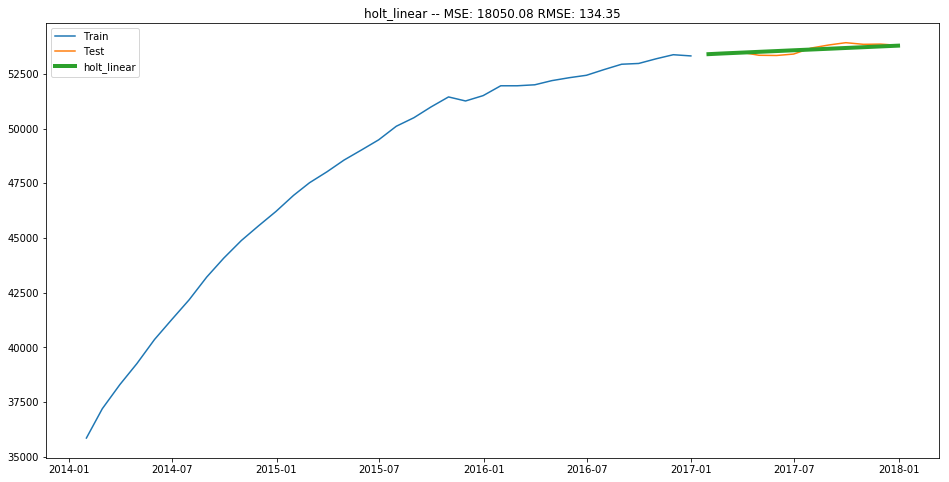

In [50]:
plot_and_eval(y_hat.holt_linear)

### Based on previous year/month/etc (your choice)

In [37]:
using_last_year = train['2016']\
    .reset_index()\
    .drop(columns='Month_Invoiced')\
    .set_index(train['2016'].index + 12)
#\
#    .iloc[:-1]

In [38]:
y_hat['last_year'] = using_last_year

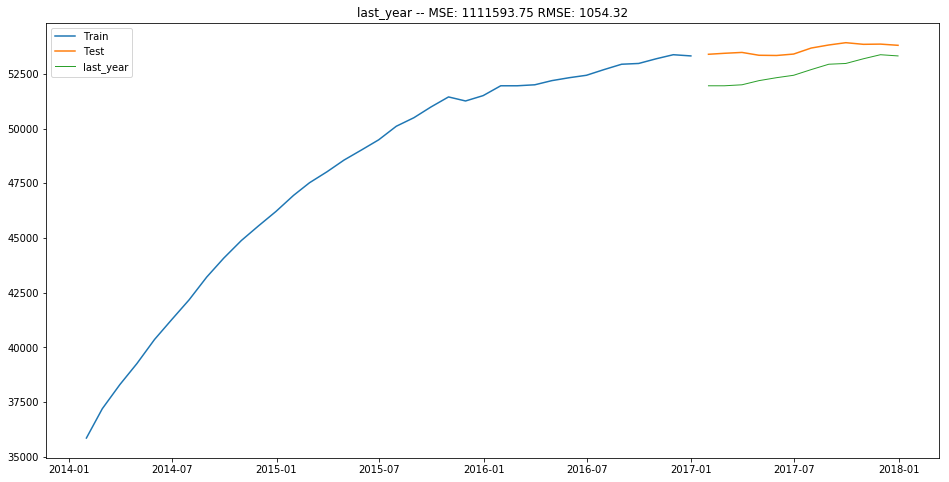

In [39]:
plot_and_eval(y_hat.last_year, linewidth=1)

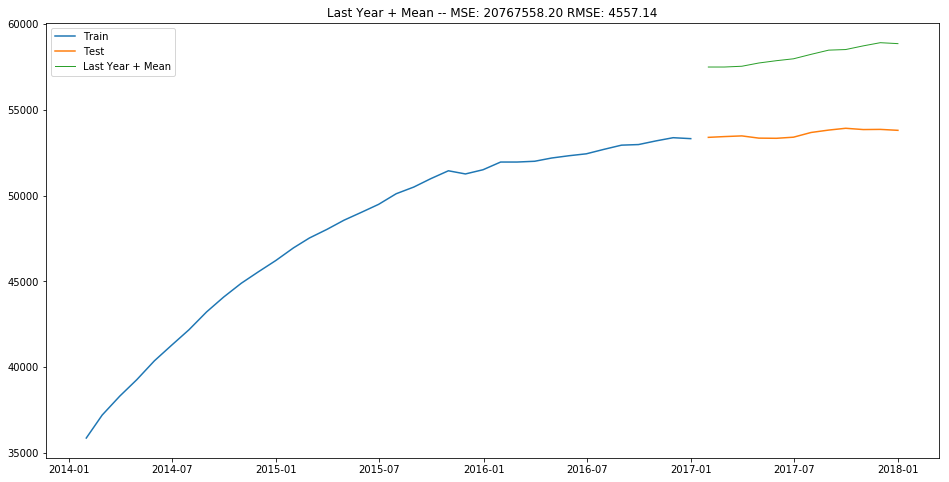

In [61]:
predictions = train['2016'] + train.diff(12).mean()
predictions.index = pd.date_range('20170101', periods=12, freq='M')
predictions = predictions
predictions.name = 'Last Year + Mean'

plot_and_eval(predictions, linewidth=1)